In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import transformers
from transformers import AutoModel
import sys
import math
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn.metrics as perf
from scipy.stats import pearsonr
sys.path.insert(0,'..')

from utils.preprocessing import load_data
from utils.transformer_dataset import ReviewDataset
from utils.training import train_text_model, train_text_meta_model, train_meta_model
from utils.evaluation import get_cls_perf, get_reg_perf, get_predictions
from models.transformer_models import UsefulScoreRegressorTextOnly, UsefulScoreRegressorAllFeat, UsefulScoreRegressorMetaOnly
from models.transformer_models import UsefulScoreRegressorLinearBaseline, DrugLinearRegression


# Set font sizes for plots
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16) 
plt.rc('figure', titlesize=16) 

# Increase dpi
plt.rcParams['figure.dpi'] = 500

In [95]:
results = pd.read_excel(open('../results.xlsx', 'rb'), sheet_name='UsefulScoreRegression')  

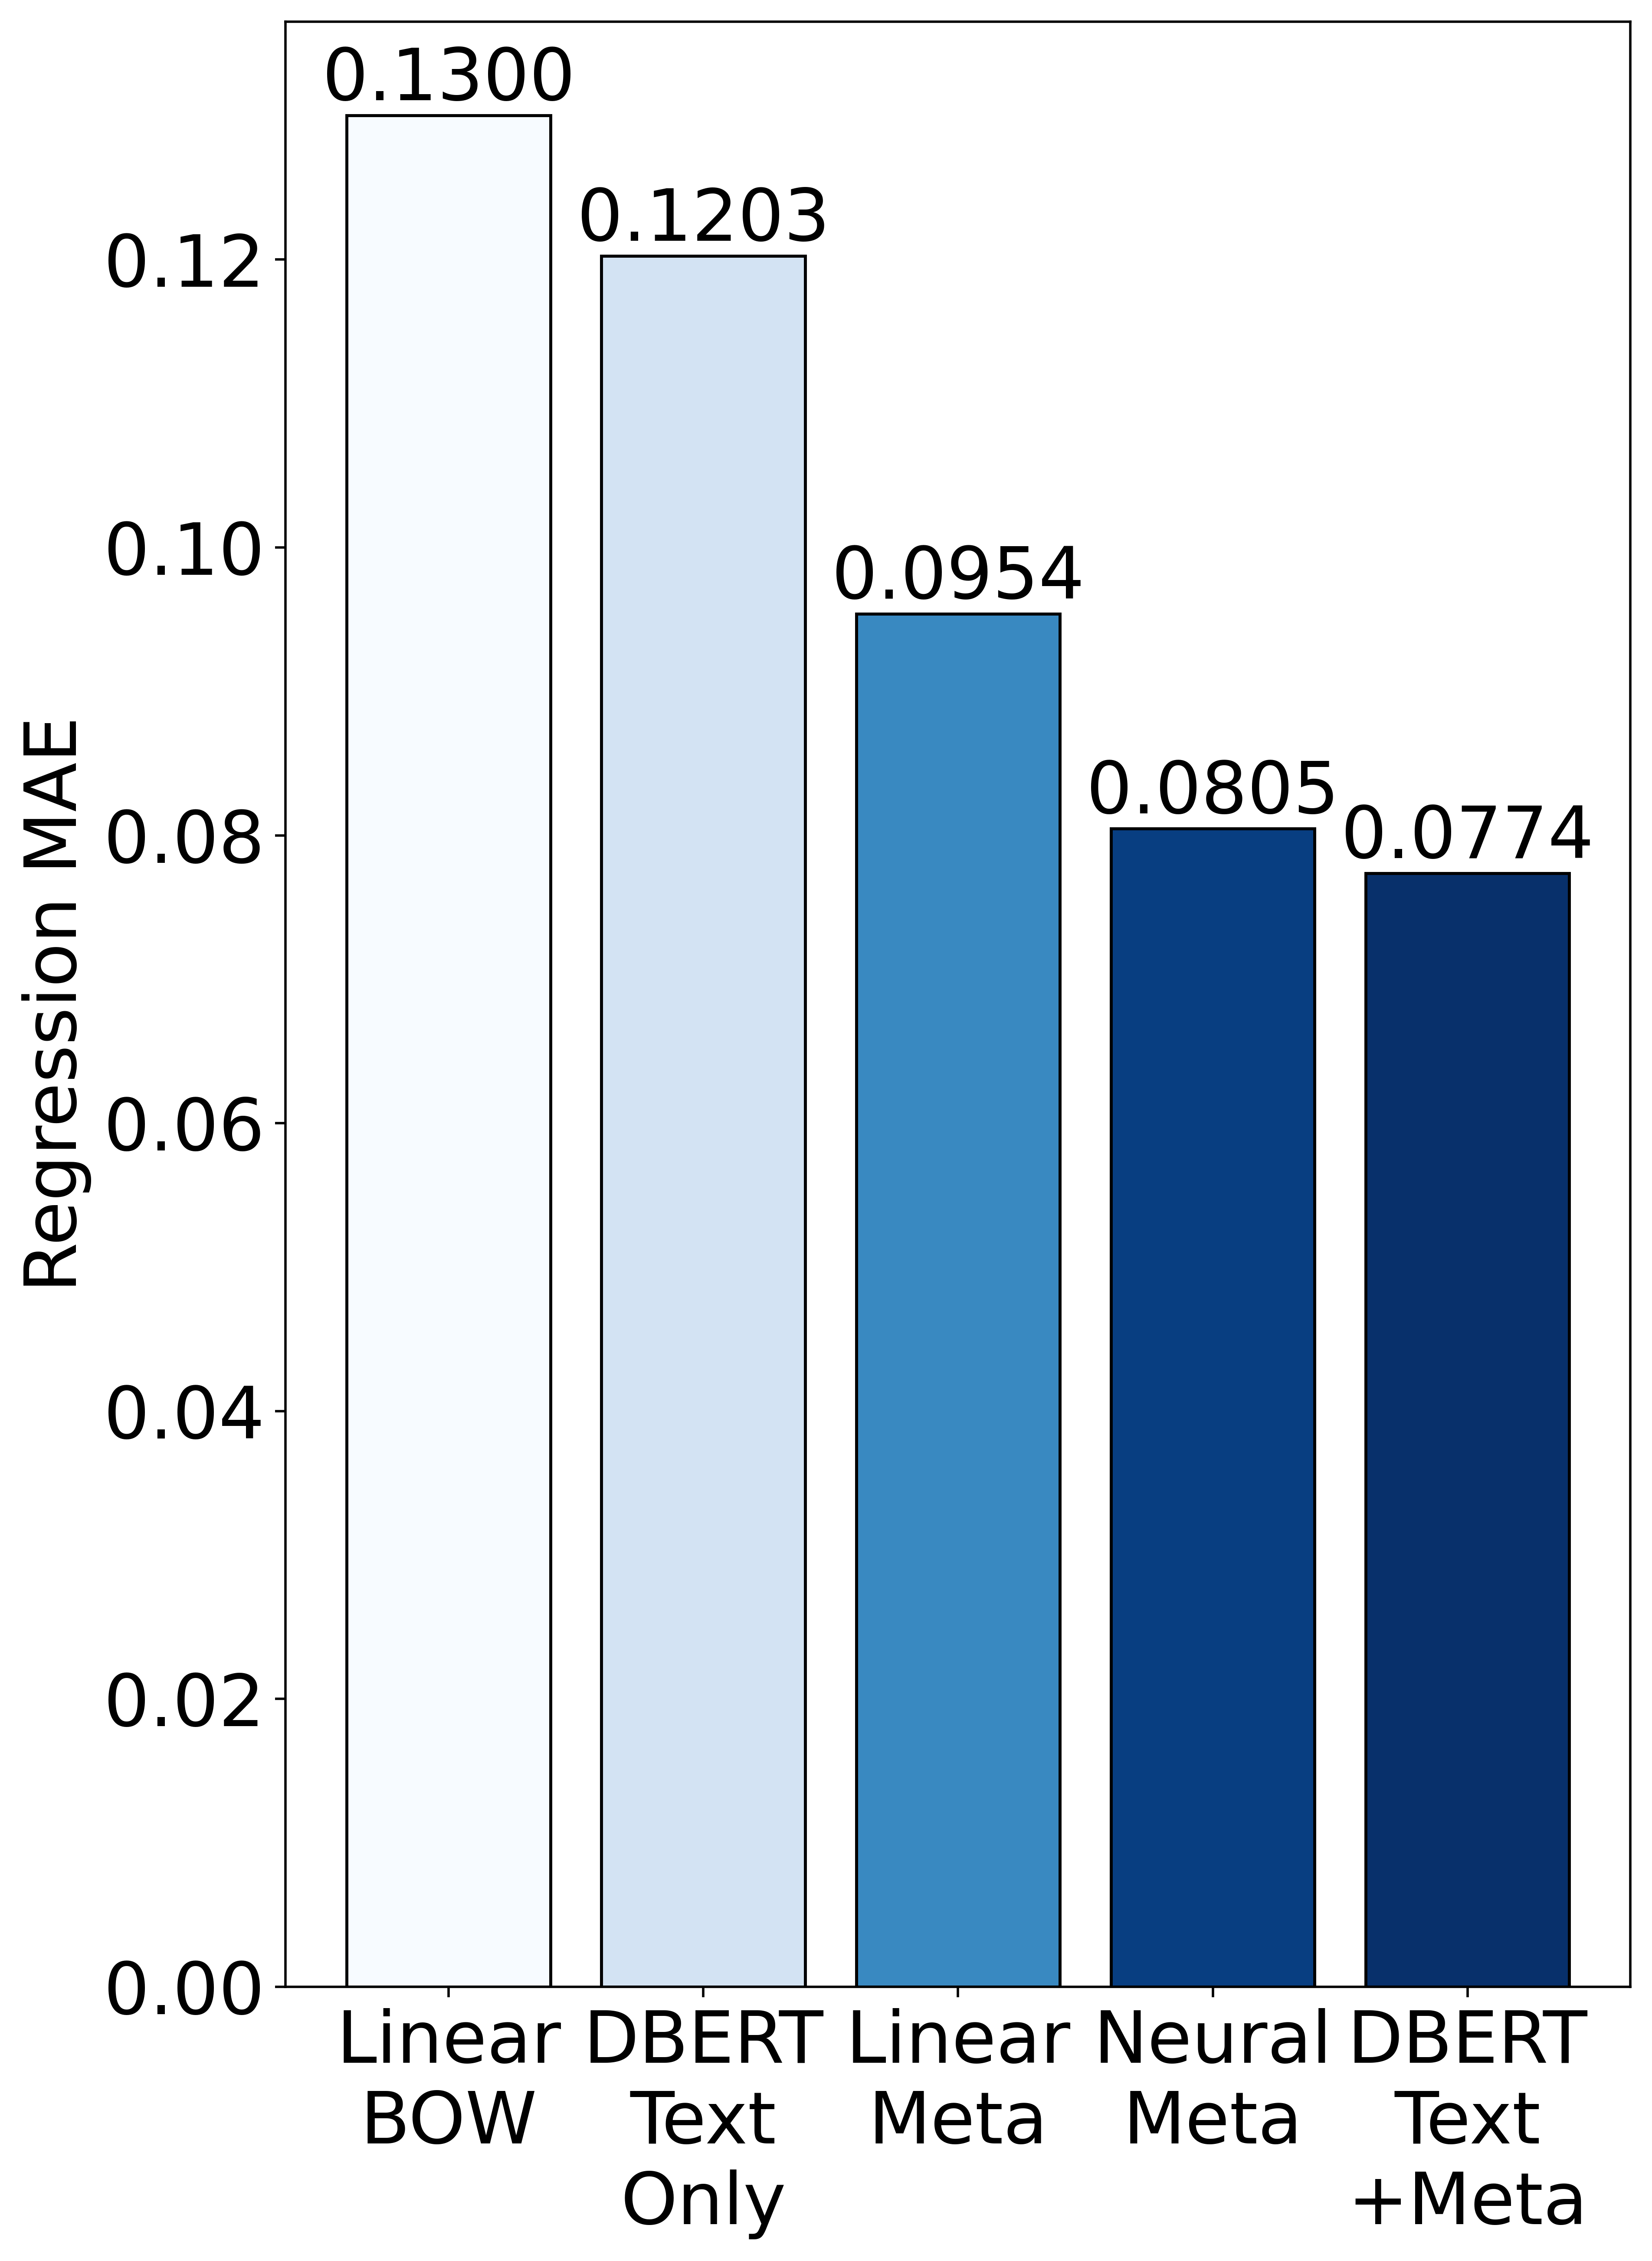

In [134]:
# Gather Data
plt.rc('font', size=24)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('legend', fontsize=24) 
plt.rc('figure', titlesize=24) 

cats = ['Linear\nMeta', 'Neural\nMeta', 'DBERT\nText\nOnly', 'DBERT\nText\n+Meta', 'Linear\nBOW']
maes = list(results['MAE'][-5:].values)
bar_vals = list(zip(cats, maes))
bar_vals = np.array(sorted(bar_vals, key=lambda x: x[1], reverse=True))

# Generate Plot
curr_cmap = plt.get_cmap('Blues_r')
scale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
fig, ax = plt.subplots(figsize=(8, 12))
bars = ax.bar(x=bar_vals[:, 0],
              height=bar_vals[:, 1].astype(float),
              color=curr_cmap(scale(bar_vals[:, 1].astype(float))), 
              linewidth=1,
              edgecolor='black')
plt.ylabel('Regression MAE')
ax.bar_label(bars, fmt='%.4f')
plt.show()

In [49]:
results_class = pd.read_excel(open('../results.xlsx', 'rb'), sheet_name='UsefulScoreClassification')  

In [50]:
results_class

,Model,ModelName,Ordinal,Text,Meta,AgeFeat,Year Range,TrainingEpochs,numClasses,F1,Accuracy
0,Linear,MetaOnly_LinearClassifierBaseline2.pt,0,0,1,0,2009-2013,10,2,0.732324,0.736744
1,Linear,MetaOnly_LinearClassifierBaseline3.pt,0,0,1,0,2009-2013,10,3,0.565793,0.572860
2,Linear,MetaOnly_LinearClassifierBaseline4.pt,0,0,1,0,2009-2013,10,4,0.446741,0.470950
3,Linear,MetaOnly_LinearClassifierBaseline5.pt,0,0,1,0,2009-2013,10,5,0.337601,0.400561
4,Neural,MetaOnly_NNClassifierBaseline2.pt,0,0,1,0,2009-2013,10,2,0.734653,0.739549
5,Neural,MetaOnly_NNClassifierBaseline3.pt,0,0,1,0,2009-2013,10,3,0.571031,0.574195
6,Neural,MetaOnly_NNClassifierBaseline4.pt,0,0,1,0,2009-2013,10,4,0.444378,0.469347
7,Neural,MetaOnly_NNClassifierBaseline5.pt,0,0,1,0,2009-2013,10,5,0.334605,0.401229
8,BERT,distilBERT_Frozen_TextOnly_Classify2.pt,0,1,0,0,2009-2013,10,2,0.708469,0.709358
9,BERT,distilBERT_Frozen_TextOnly_Classify3.pt,0,1,0,0,2009-2013,10,3,0.553530,0.548722


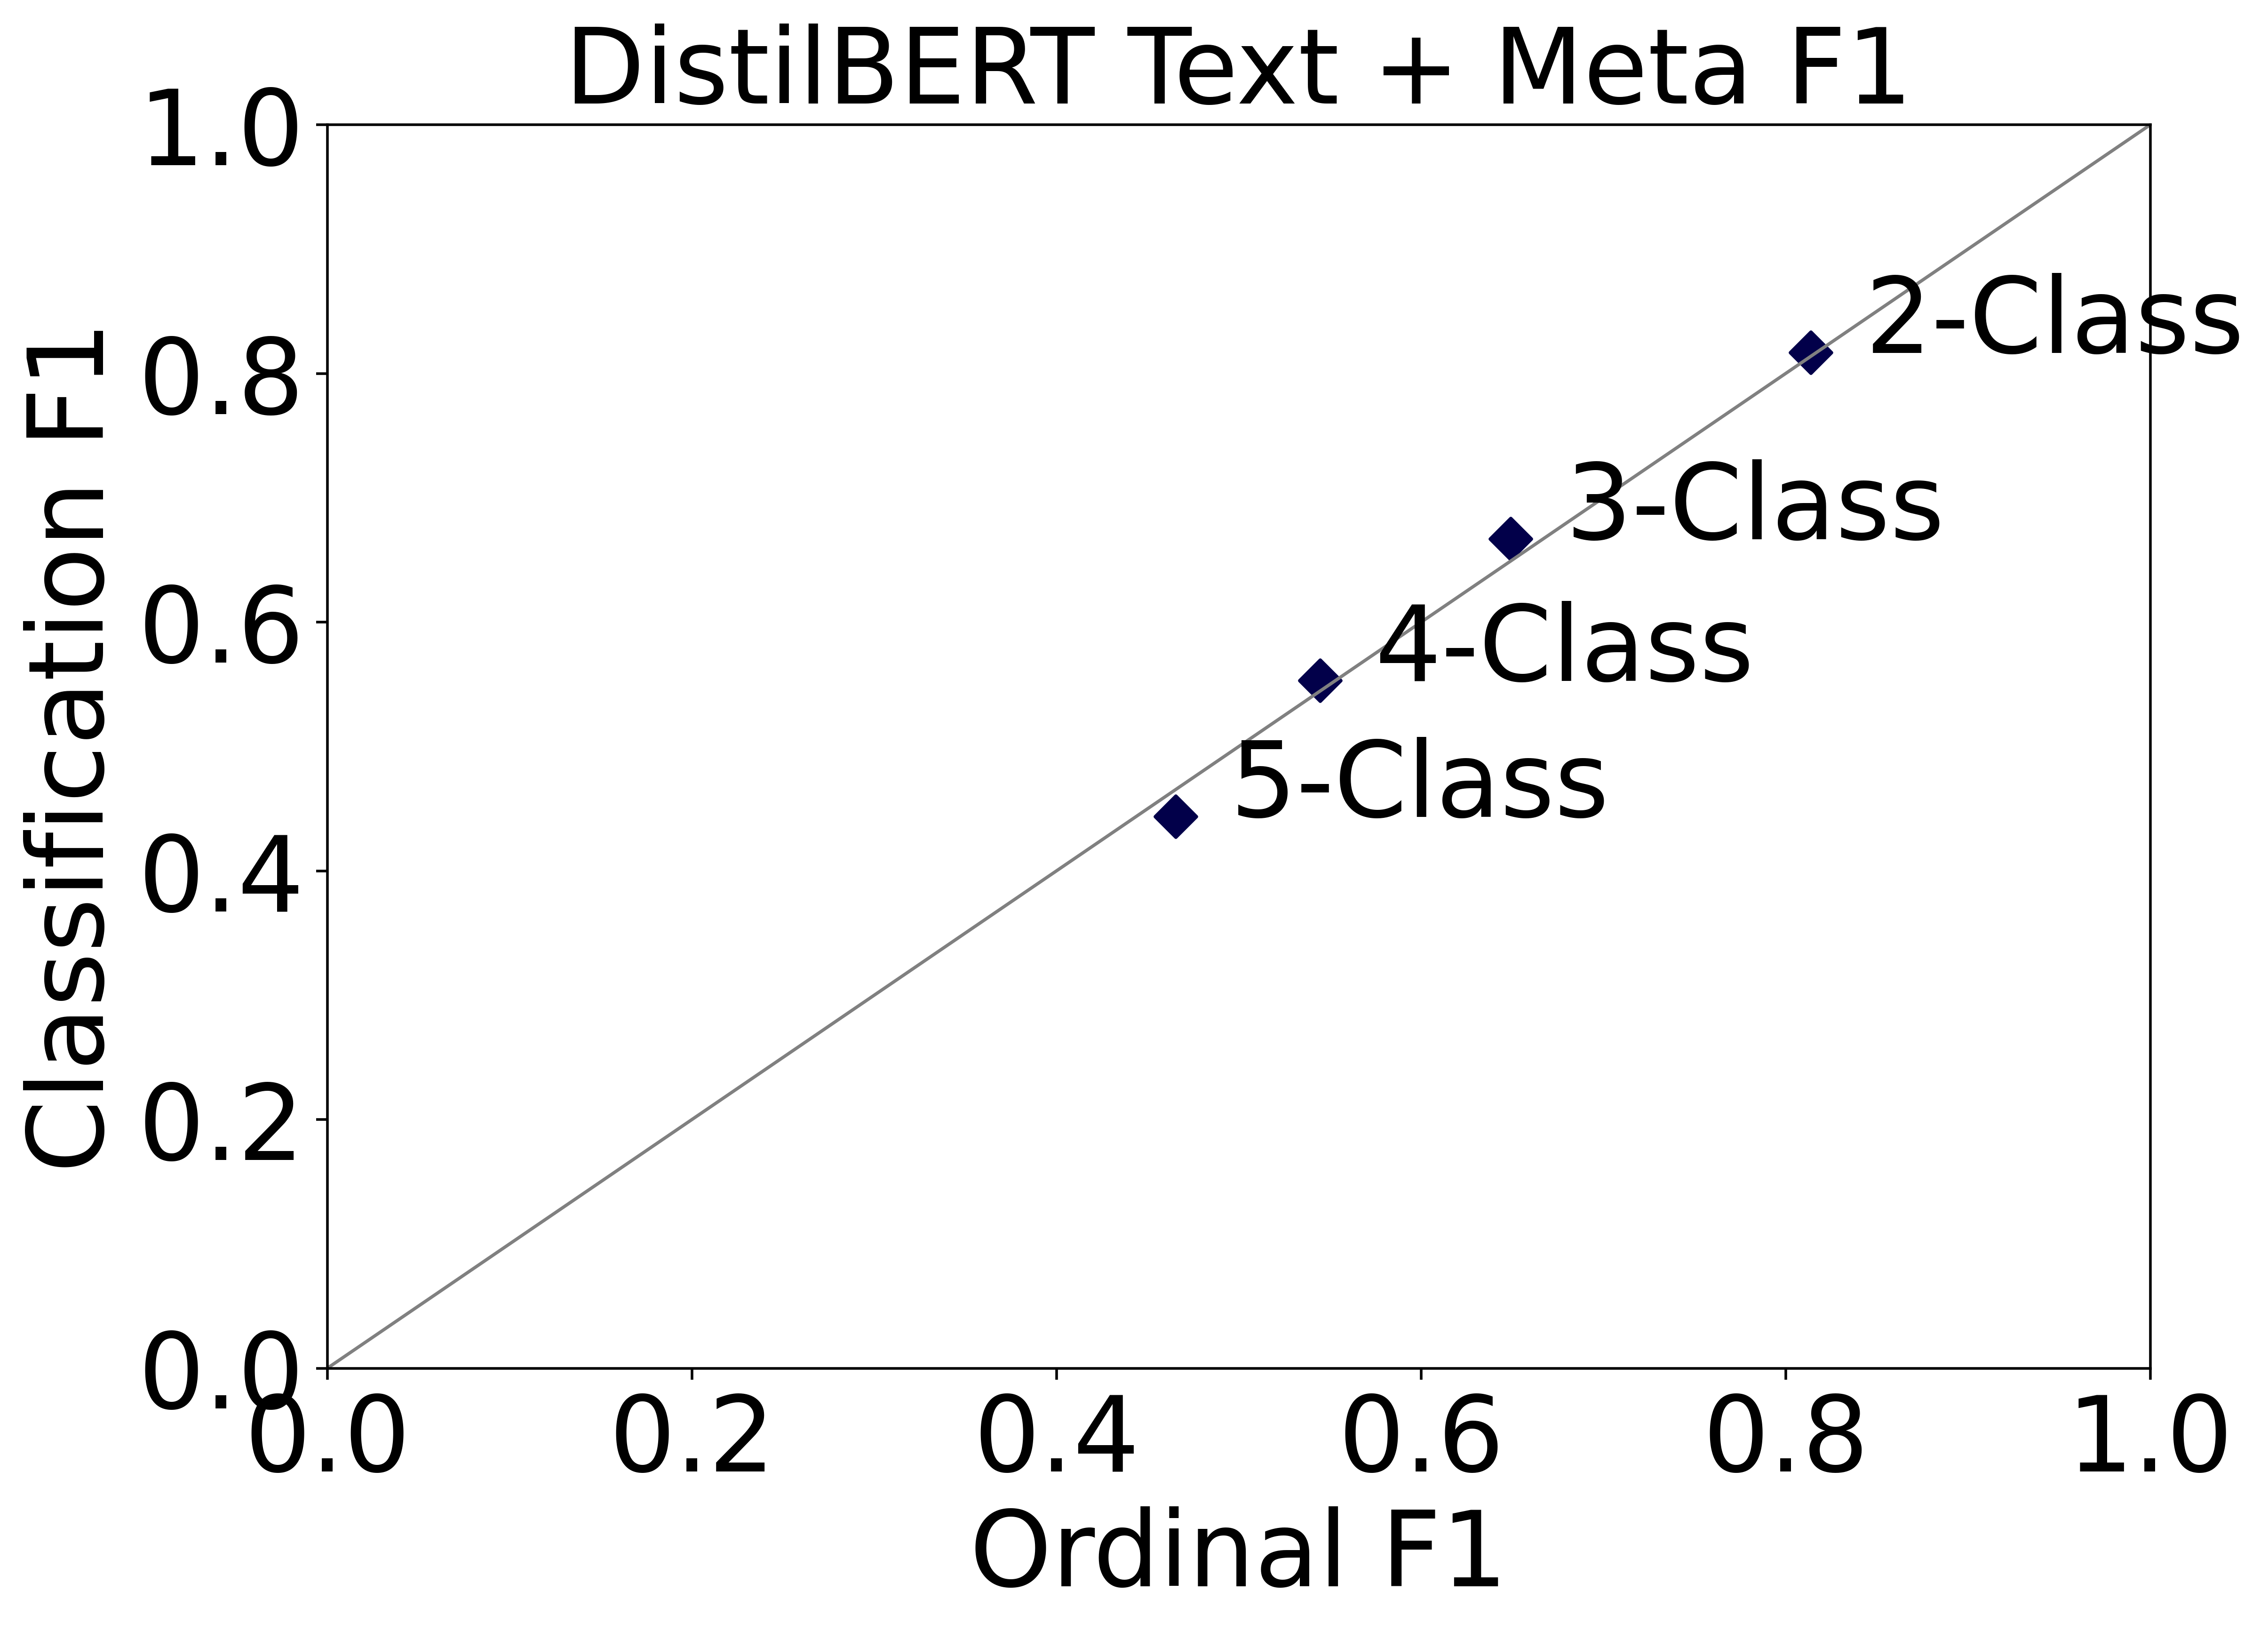

In [136]:
plt.rc('font', size=32)
plt.rc('axes', titlesize=32)
plt.rc('axes', labelsize=32)
plt.rc('xtick', labelsize=32)
plt.rc('ytick', labelsize=32)
plt.rc('legend', fontsize=32) 
plt.rc('figure', titlesize=32) 


ordinal_f1 = results_class.loc[(results_class['Ordinal']==1) & (results_class['AgeFeat']==1), 'F1']
class_f1 = results_class.loc[(results_class['Ordinal']==0) & (results_class['AgeFeat']==1), 'F1']

fig, ax = plt.subplots(figsize=(10, 7))
plt.scatter(ordinal_f1, class_f1, marker='D', color='#02004a', s=80)
ax.set_ylabel('Classification F1')
ax.set_xlabel('Ordinal F1')

# Plot y = x  
ax.set_ylim([0, 1])
ax.set_xlim([0, 1])
x = y = ax.get_xlim()
ax.plot(x, y, linestyle='-', color='gray', lw=1, scalex=False, scaley=False)
labels = ['2-Class', '3-Class', '4-Class', '5-Class']

for i, anno in enumerate(labels):
    ax.annotate(anno, (list(ordinal_f1)[i]+0.03, list(class_f1)[i]))
    
ax.set_title('DistilBERT Text + Meta F1')

plt.show()

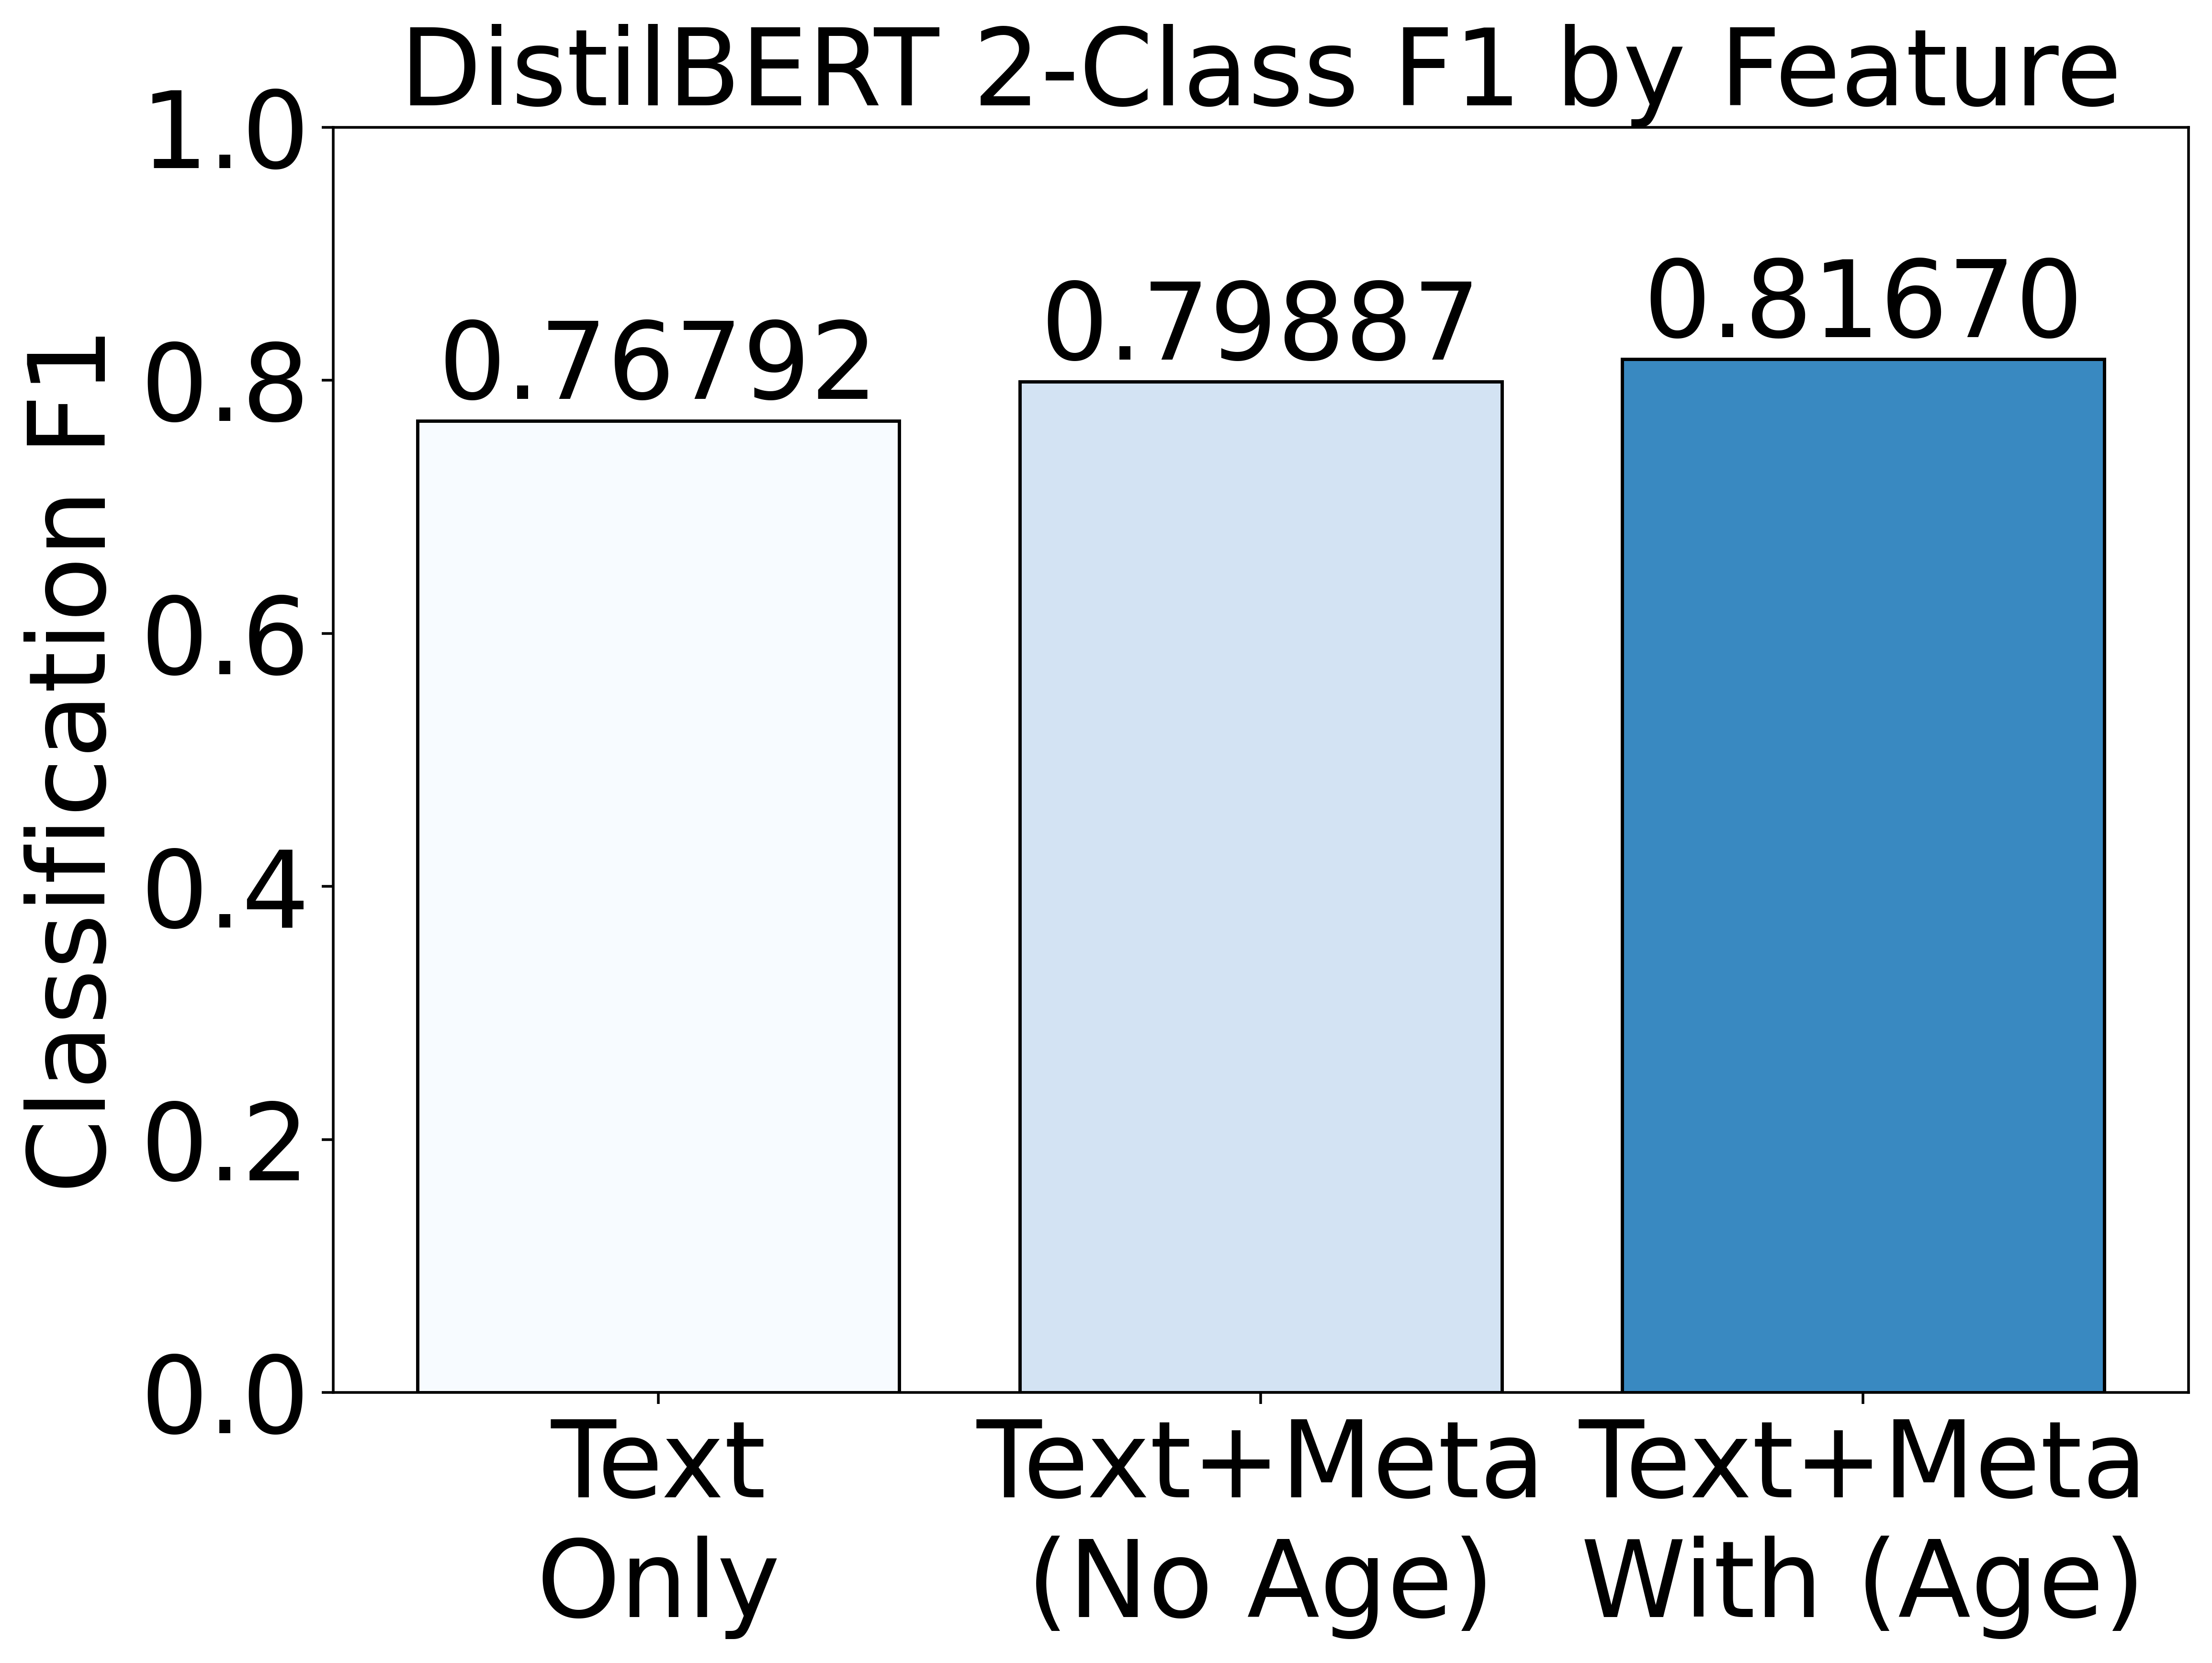

In [137]:
### Show how each feature contributes to DistilBERT performance
labels = ['Text\nOnly', 'Text+Meta\n(No Age)', 'Text+Meta\nWith (Age)']
lookup = (results_class['Ordinal']==0) & (results_class['numClasses']==2) & (results_class['Year Range']=='2013-2017')
f1 = sorted(list(results_class.loc[lookup, 'F1']), reverse=False)

# Generate Plot
curr_cmap = plt.get_cmap('Blues_r')
scale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(x=labels,
              height=f1,
              color=curr_cmap(scale(bar_vals[:, 1].astype(float))), 
              linewidth=1,
              edgecolor='black')
plt.ylabel('Classification F1')
ax.bar_label(bars, fmt='%.5f')
ax.set_title('DistilBERT 2-Class F1 by Feature')
ax.set_ylim([0, 1])
plt.show()